In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import get_dummies
import math

plt.style.use('ggplot')

In [7]:
from __future__ import print_function

import sys
from Bio.SeqUtils import ProtParamData  # Local
from Bio.SeqUtils import IsoelectricPoint  # Local
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

In [8]:
from sklearn import preprocessing

## Features from BioPython. Protein analysis

In [9]:
def analyse_scale_seq(data):
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in data["sequence"]:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    data["molecular_weight"] = mol_weight
    data["aromaticity"] = aromaticity
    data["instability_index"] = instability_index
    data["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(data[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    data["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    data["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    data["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])

In [10]:
data_example = pd.read_csv("A0203.csv")
analyse_scale_seq(data_example)
data_example.tail()

OSError: File b'A0203.csv' does not exist

## Preprocessing. Scaling

In [11]:
data = pd.read_csv("Ext.csv", sep=",")
data.drop(["Unnamed: 0"], inplace=True, axis=1)
data.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp
2121,YVYPDNLPR,9,0.084693,0.120446,0.094057,0.280906
2122,YVYPDNLPV,9,0.898488,0.765906,0.785698,0.708660
2123,YWIREGKII,9,0.000000,0.080011,0.035959,0.086183
2124,YWMGGTTYF,9,0.350922,0.257071,0.220255,0.362626
2125,YYFSYPLFV,9,0.550114,0.668012,0.656733,0.675035


In [12]:
analyse_scale_seq(data)
data.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp,molecular_weight,aromaticity,instability_index,isoelectric_point
2121,YVYPDNLPR,9,0.084693,0.120446,0.094057,0.280906,0.548323,0.222222,0.231246,0.266668
2122,YVYPDNLPV,9,0.898488,0.765906,0.785698,0.708660,0.478572,0.222222,0.335037,0.046140
2123,YWIREGKII,9,0.000000,0.080011,0.035959,0.086183,0.598616,0.222222,0.090546,0.565215
2124,YWMGGTTYF,9,0.350922,0.257071,0.220255,0.362626,0.534869,0.444444,0.262926,0.232936
2125,YYFSYPLFV,9,0.550114,0.668012,0.656733,0.675035,0.624251,0.555556,0.292049,0.232856


In [13]:
#it was done in R
from math import log
def logmeas(i):
    val = np.linspace(1, np.log(i)/np.log(50000))
    return 1 - min(val)

In [14]:
"""def select_len(data, len):
    len_indexes = data['sequence'][data['length'] == len].index
    sel_len_X = data["sequence"][indexes]
    """

'def select_len(data, len):\n    len_indexes = data[\'sequence\'][data[\'length\'] == len].index\n    sel_len_X = data["sequence"][indexes]\n    '

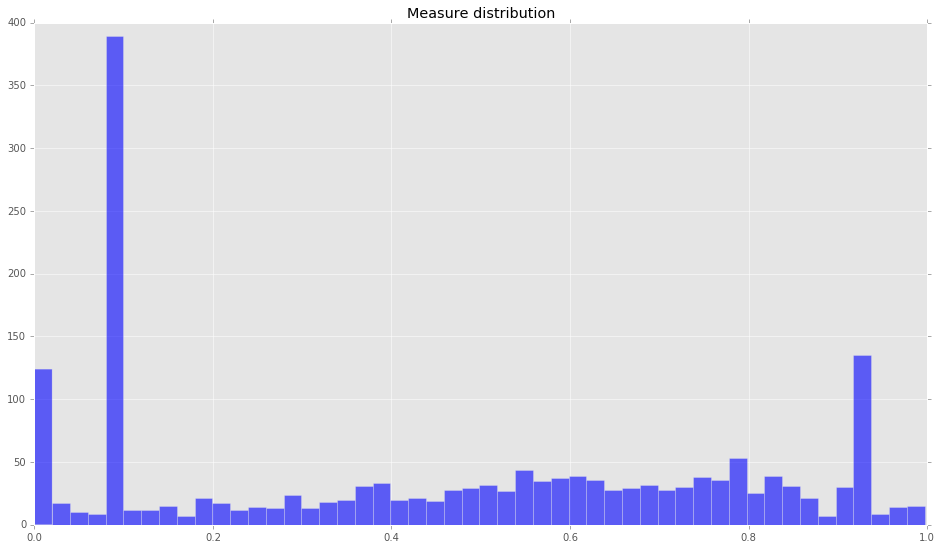

In [15]:
indexes = data['sequence'][data['length'] == 9].index
#indexes = data.index
selected_X = data["sequence"][indexes]

selected_y = pd.DataFrame(data['meas'][indexes])
selected_y['netmhc'] = pd.DataFrame(data['netmhc'][indexes])
selected_y['netmhcpan'] = pd.DataFrame(data['netmhcpan'][indexes])
selected_y['smmpmbec_cpp'] = pd.DataFrame(data['smmpmbec_cpp'][indexes])

plt.figure(figsize=(16,9))
plt.title("Measure distribution")
hh = plt.hist(selected_y['meas'], 50, color = 'blue', alpha = 0.6)

In [16]:
letters_X = selected_X.apply(list)
selected_X=pd.get_dummies(pd.DataFrame(list(letters_X)))

In [17]:
selected_X["molecular_weight"] = pd.DataFrame(data["molecular_weight"][indexes]).reset_index(drop=True)
selected_X["instability_index"] = pd.DataFrame(data["instability_index"][indexes]).reset_index(drop=True)
selected_X["isoelectric_point"] = pd.DataFrame(data["isoelectric_point"][indexes]).reset_index(drop=True)
selected_X["aromaticity"] = pd.DataFrame(data["aromaticity"][indexes]).reset_index(drop=True)

## SVR. 1Hot

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

In [19]:
mse_netmhc = mean_squared_error(selected_y["meas"], selected_y["netmhc"])
mse_netmhcpan = mean_squared_error(selected_y["meas"], selected_y["netmhcpan"])
mse_smmpmbec_cpp = mean_squared_error(selected_y["meas"], selected_y["smmpmbec_cpp"])

In [20]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [21]:
def SVR_res(train_x, test_x, train_y, test_y):
    
    """k=['rbf', 'linear','poly','sigmoid','precomputed']
    c= [1e-3, 1e0, 1e1, 1e2, 1e3]
    g=np.arange(1e-4,1e-2,0.0001)
    g=g.tolist()
    param_grid1=dict(kernel=k, C=c, gamma=g)  
    grid = GridSearchCV(SVR(), cv=5,param_grid=param_grid1,)
    grid.fit(train_x, train_y)   
    params = list(grid.best_params_.values())
    TunedSVR = SVR(kernel=params[0], C=params[1], gamma=params[2])
    TunedSVR.fit(train_x, train_y)"""
    TunedSVR = SVR(kernel='rbf', C=1, gamma=0.10000001)
    TunedSVR.fit(train_x, train_y)
    editedPredict = TunedSVR.predict(test_x)
    editedPredict = editedPredict.clip(min=0)
    editedPredict = editedPredict.clip(max=1)
    print("SVR MSE:", mean_squared_error(test_y, editedPredict))
    print("netmhc MSE:", mse_netmhc)
    print("netmhcpan MSE:", mse_netmhcpan)
    print("smmpmbec_cpp MSE:", mse_smmpmbec_cpp)
    plt.plot(editedPredict, test_y, 'ro')

In [22]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y["meas"],
                                                test_size = 0.33, random_state = random_number)


SVR MSE: 0.0377751002332
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


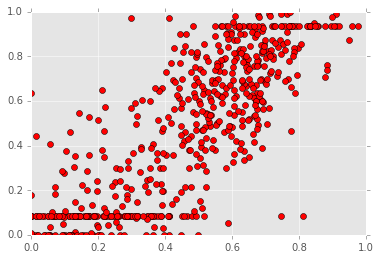

In [23]:
SVR_res(X_train, X_test, y_train, y_test)

## Kidera features

In [24]:
amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
kidera_selected = selected_X.copy(deep=True)
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']
 
def kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

In [25]:
for i,fact in enumerate(f): 
    data[fact]=[round(kidera(j)[i], 3) for j in data['sequence']]
    kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)

## SVR. 1Hot + Kidera

In [26]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(kidera_selected, selected_y["meas"],
                                                test_size = 0.33, random_state = random_number)


SVR MSE: 0.0374757953207
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


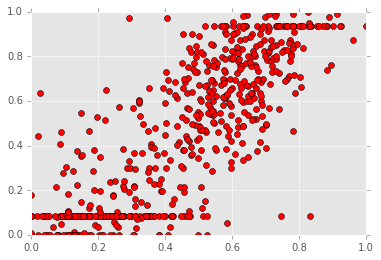

In [27]:
SVR_res(X_train, X_test, y_train, y_test)

## SVR. Kidera

In [28]:
kidera_only = kidera_selected[kidera_selected.columns[len(kidera_selected.columns)-14:len(kidera_selected.columns)]]

In [29]:
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(kidera_only, selected_y["meas"],
                                                test_size = 0.33, random_state = random_number)


SVR MSE: 0.0753159901687
netmhc MSE: 0.0289021865583
netmhcpan MSE: 0.0289280856635
smmpmbec_cpp MSE: 0.0331315186522


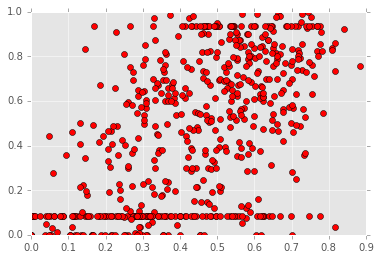

In [30]:
SVR_res(X_train, X_test, y_train, y_test)

In [31]:
#kidera sucks

## Word2Vec

In [81]:
import math

def log_(num):
    return 1-math.log(num,50000)

In [84]:
Merged_data = pd.read_csv("Merged.csv")
Merged_data.drop(["Unnamed: 0"], inplace=True, axis=1)

In [85]:
BData = pd.read_csv("bdata.csv", sep=",")

In [69]:
#BData[BData["peptide_length"]==9]["species"]

In [60]:
Merged_data[Merged_data["length"]==10].tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp
27661,YTAFTLPSVN,10,2529.297996,236.591970,1406.047524,14.487719
27662,YTDGSCNKQS,10,11091.748153,4345.102242,11246.049740,588.843655
27667,YTSGPGIRYP,10,7128.530301,783.429643,5176.068320,1270.574105
27668,YTSGPGTRYP,10,3097.419299,483.058802,5420.008904,797.994687
27673,YTYEAYVRYP,10,2624.218543,1552.387010,3872.576449,1954.339456


In [134]:
cur_indexes = BData[BData["mhc"] == "HLA-C*12:03"].index
df=BData["sequence"][indexes]


0       ALFYKDGKL
1       ALYEKKLAL
2       AMKDRFQPL
3       AQRELFFTL
4       FMKVKFEAL
5       FQHERLGQF
6       FQRAIMNAM
7       GQFLSFASL
8       GQFNRYAAM
9       ILNHKFCNL
10      IMALKQAGL
11      IQYDRRSFF
12      IQYVIRAQL
13      KMNAKAATL
14      KQFCLSILL
15      KQIPIWLPL
16      KQLELFWVI
18      LLRRRPYPL
19      LQLARDGMF
20      LQYAIRSVF
21      MLKRRGFHL
22      MSRRRIYVL
23      RARQKGCTL
24      RARRHLAAL
25      RIHDIAVQL
26      RIYRKGNPL
27      RLARRARNI
28      RLKHIFLIF
29      RLRRRRHPL
30      RMAMIPRTL
          ...    
2094    LALMDLLMF
2095    LALVAAFAL
2096    LAMATMDLI
2097    LAMSNELHL
2098    LAMSPRTSI
2099    LANDYARKI
2100    LANLNIHTI
2101    LANSHQRSD
2102    LAPGSGVPV
2103    LAPHFAKLI
2104    LAPNNVSEL
2105    LAPVNFDAL
2106    LAPVPKTPL
2107    LARFNPDAV
2108    LASANRDVL
2110    LAVAGVTLV
2111    LAVTIMAIL
2112    LAVVLWSLL
2113    LAVVSVSPL
2114    LAVVTLLAI
2115    LDSQNRKDI
2116    LDYLRQAGL
2117    LDYVNLEAV
2118    LECFVRSSP
2120    LF

In [93]:
human = BData[BData["species"]=="human"]
human.tail()

,species,mhc,peptide_length,cv,sequence,inequality,meas
179687,human,HLA-C*12:03,9,TBD,IMDEPTSSL,=,1.0
179688,human,HLA-C*12:03,9,TBD,DAMPGVLSY,=,1.0
179689,human,HLA-C*12:03,9,TBD,YYFQSGNEI,=,1.0
179690,human,HLA-C*12:03,9,TBD,LMDENTYAM,=,1.0
179691,human,HLA-C*12:03,9,TBD,FAAFYFVFI,=,1.0


In [114]:
import os
import glob

def get_csv_by_mhc(name):
    path = "C:/Users/Lev/.babun/cygwin/home/Lev/mhcflurry/experiments/combined-test-data/mhc/for_merge"
    cur_name = name[-5:len(name)].replace(":", "")
    cur_csv = pd.DataFrame("A" + name)

In [117]:

#your path to folder with .csv files


In [136]:
unique_peptides=pd.DataFrame(columns=BData.columns)

In [141]:
path = "C:/Users/Lev/.babun/cygwin/home/Lev/mhcflurry/experiments/combined-test-data/mhc/for_merge"
allfiles = glob.glob(os.path.join(path,"*.csv"))
mhc_ = pd.unique(BData["mhc"].values.ravel())
for file_ in allfiles:
    mhc_df = pd.read_csv(file_,index_col=None, header=0)
    cur_mhc_df = BData[BData["mhc"] == mhc_[i]]
    unique_peptides=pd.concat([cur_mhc_df[~cur_mhc_df.sequence.isin(mhc_df.sequence)]]) 
    

In [142]:
unique_peptides.to_csv("C:/Users/Lev/.babun/cygwin/home/Lev/mhcflurry/experiments/combined-test-data/mhc/unique_peptides.csv")

In [126]:
len(dict(unique_peptides["sequence"]))

174163

In [128]:
len(pd.unique(unique_peptides["sequence"].values.ravel()))

42062

In [129]:
ex=BData.tail()[~BData.tail().sequence.isin(df.tail().sequence)]

In [135]:
BData

,species,mhc,peptide_length,cv,sequence,inequality,meas
0,cow,BoLA-HD6,9,TBD,ALFYKDGKL,=,1.000000
1,cow,BoLA-HD6,9,TBD,ALYEKKLAL,=,1.000000
2,cow,BoLA-HD6,9,TBD,AMKDRFQPL,=,4.521706
3,cow,BoLA-HD6,9,TBD,AQRELFFTL,=,1.000000
4,cow,BoLA-HD6,9,TBD,FMKVKFEAL,=,1.576747
5,cow,BoLA-HD6,9,TBD,FQHERLGQF,=,1.000000
6,cow,BoLA-HD6,9,TBD,FQRAIMNAM,=,1.000000
7,cow,BoLA-HD6,9,TBD,GQFLSFASL,=,1.000000
8,cow,BoLA-HD6,9,TBD,GQFNRYAAM,=,1.000000
9,cow,BoLA-HD6,9,TBD,ILNHKFCNL,=,1.000000


In [131]:
BData.tail()

,species,mhc,peptide_length,cv,sequence,inequality,meas
179687,human,HLA-C*12:03,9,TBD,IMDEPTSSL,=,1.0
179688,human,HLA-C*12:03,9,TBD,DAMPGVLSY,=,1.0
179689,human,HLA-C*12:03,9,TBD,YYFQSGNEI,=,1.0
179690,human,HLA-C*12:03,9,TBD,LMDENTYAM,=,1.0
179691,human,HLA-C*12:03,9,TBD,FAAFYFVFI,=,1.0


In [132]:
df.tail()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp
440,YRHDGGNVL,9,78162.780459,28119.008304,38018.939632,231206.479018
441,YTGDFDSVI,9,11376.272858,7046.930690,2600.159563,1927.524913
442,YTTDVNQLY,9,35.974934,258.821292,129.121927,393.550075
443,YVADALAAF,9,11748.975549,2636.331386,1603.245391,1655.769963
444,YVIKVSARV,9,78162.780459,11428.783348,17338.039978,8609.937522
